In [1]:
import os
import io
import numpy as np
import pandas as pd
import itertools as it
from matplotlib import pyplot as plt
from PIL import Image
from dataclasses import dataclass
from time import time
from typing import Callable, Any
from tqdm import tqdm
import plotly.express as px

import utils
from decoder import Decoder as BruteForceDecoder
from jit_bfencoder import JitedBruteForceEncoder
from quadtree.encoder import QuadtreeEncoder
from quadtree.decoder import QuadtreeDecoder
from quadtree.common import EncodingInfo
from quadtree.serialization import QuadtreeSerializer, QuadtreeDeserializer

In [2]:
def load_img(path: str) -> np.ndarray:
    return utils.load_grayscale(path)

def kalafior(size: int) -> np.ndarray:
    return load_img(f'../imgs/raw/cauliflower_{size}x{size}_colored.png')

def rectangular_kalafior(width: int, height: int) -> np.ndarray:
    return load_img(f'../imgs/raw/cauliflower_{width}x{height}_colored.png')

def lena(size: int):
    return load_img(f'../imgs/raw/lena_{size}x{size}_grayscale.bmp')

def rectangular_lena(width: int, height: int) -> np.ndarray:
    return load_img(f'../imgs/raw/lena_{width}x{height}_colored.bmp')

def save_grayscale(src_path: str, dest_path: str):
    with Image.open(src_path) as im:
        im_gray = im.convert("L")
        im_gray.save(dest_path)

def show_img(img: np.ndarray, ax):
    ax.imshow(img, cmap='gray')
    ax.set_xticks([])
    ax.set_yticks([])

In [3]:
@dataclass
class CodecInfo:
    encoding: Any
    decoded_img: np.ndarray
    encoding_time: float
    decoding_time: float
    decoding_iterations: int

In [4]:
def encode_decode_jpeg(img: np.ndarray) -> CodecInfo:
    with io.BytesIO() as bytes_io:
        start = time()
        Image.fromarray(img).save(bytes_io, format="JPEG")
        encoding_time = time() - start

        start = time()
        bytes_io.seek(0)
        decoded_img = np.asarray(Image.open(bytes_io))
        decoding_time = time() - start
    return CodecInfo(None, decoded_img, encoding_time, decoding_time, 0)

In [5]:
def encode_decode_bruteforce(img: np.ndarray, decoding_iterations=32, show_error_stats=False) -> CodecInfo:
    start = time()
    encoder = JitedBruteForceEncoder(img)
    encoded_img, errs = encoder.encode()
    encoding_time = time() - start

    start = time()
    decoder = BruteForceDecoder()
    decoded_img = decoder.decode(encoded_img, iterations=decoding_iterations)
    decoding_time = time() - start

    if show_error_stats:
        plt.hist(errs)

    return CodecInfo(encoded_img, decoded_img, encoding_time, decoding_time, decoding_iterations)

In [9]:
def encode_decode_quadtree(img: np.ndarray, encoder: QuadtreeEncoder=None, decoding_iterations=32) -> CodecInfo:
    if encoder is None:
        encoder = QuadtreeEncoder(7, 5, 1., False, False, 4, 32, 2.)
    start = time()
    encoded_img = encoder.encode(img)
    encoding_time = time() - start

    start = time()
    decoded_img = QuadtreeDecoder(encoded_img).decode(decoding_iterations, stop_on_relative_error=5e-4, log_stop=True)
    decoding_time = time() - start

    return CodecInfo(encoded_img, decoded_img, encoding_time, decoding_time, decoding_iterations)

In [7]:
@dataclass
class Metrics:
    squared_error: float
    mse: float
    psnr: float
    encoding_time: str
    decoding_time: str

def compute_metrics(original_img: np.ndarray, codec_info: CodecInfo) -> Metrics:
    squared_error = np.linalg.norm(original_img.astype(np.int32) - codec_info.decoded_img.astype(np.int32))
    mse = squared_error / (original_img.shape[0] * original_img.shape[1])
    psnr = 10 * np.log10(255. / mse)
    return Metrics(squared_error, mse, psnr, f'{codec_info.encoding_time:.4f}s', f'{codec_info.decoding_time:.4f}s')

def compare_encoding(original_img: np.ndarray, codec_info: CodecInfo):
    jpeg_info = encode_decode_jpeg(original_img)
    fig, axs = plt.subplots(1, 3, figsize=(18, 6))
    fig.suptitle(f"Image size: {original_img.shape[1]}x{original_img.shape[0]}")
    imgs = [original_img, codec_info.decoded_img, jpeg_info.decoded_img]
    titles = ["Original", "Fractal compressed", "JPEG compressed"]
    for ax, img, title in zip(axs, imgs, titles):
        show_img(img, ax)
        ax.set_title(title)
    plt.show()

    print('Fractal compression:')
    print(compute_metrics(original_img, codec_info))

    print('JPEG (PIL defaults):')
    print(compute_metrics(original_img, jpeg_info))

In [ ]:
def compare_per_iteration_results(decoder: Callable[[int], tuple[np.ndarray, float]]):
    iters = [1, 2, 4, 8, 16, 32]
    fig, axs = plt.subplots(2, 3, figsize=(18, 12))
    results = []
    for i, it_num in enumerate(iters):
        decoded_img, err = decoder(it_num)
        ax = axs[i//3][i%3]
        show_img(decoded_img, ax)
        ax.set_title(f'{it_num} iterations')
        results.append(err)
    plt.show()

    plt.plot(iters, results)
    plt.title("| original - decoded |")
    plt.ylabel('error')
    plt.xlabel('iterations')
    # plt.xscale('log')
    plt.show()

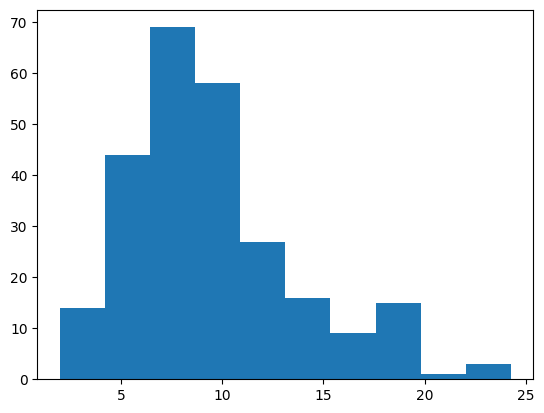

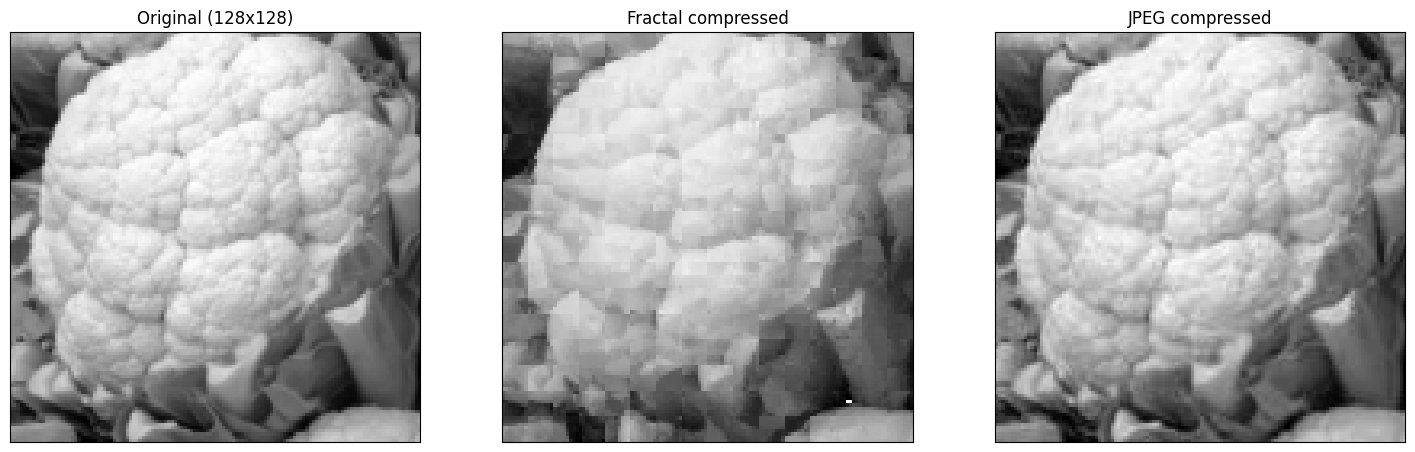

Fractal compression:
Metrics(squared_error=1411.7712279261114, mse=0.08616767748572457, psnr=34.711957930556004, encoding_time='16.1182s', decoding_time='0.0721s')
JPEG (PIL defaults):
Metrics(squared_error=541.4065016233181, mse=0.0330448304213451, psnr=38.87436652923619, encoding_time='0.0001s', decoding_time='0.0001s')


In [ ]:
img = kalafior(128)
bruteforce_encoding = encode_decode_bruteforce(img, show_error_stats=True)
compare_encoding(img, bruteforce_encoding)

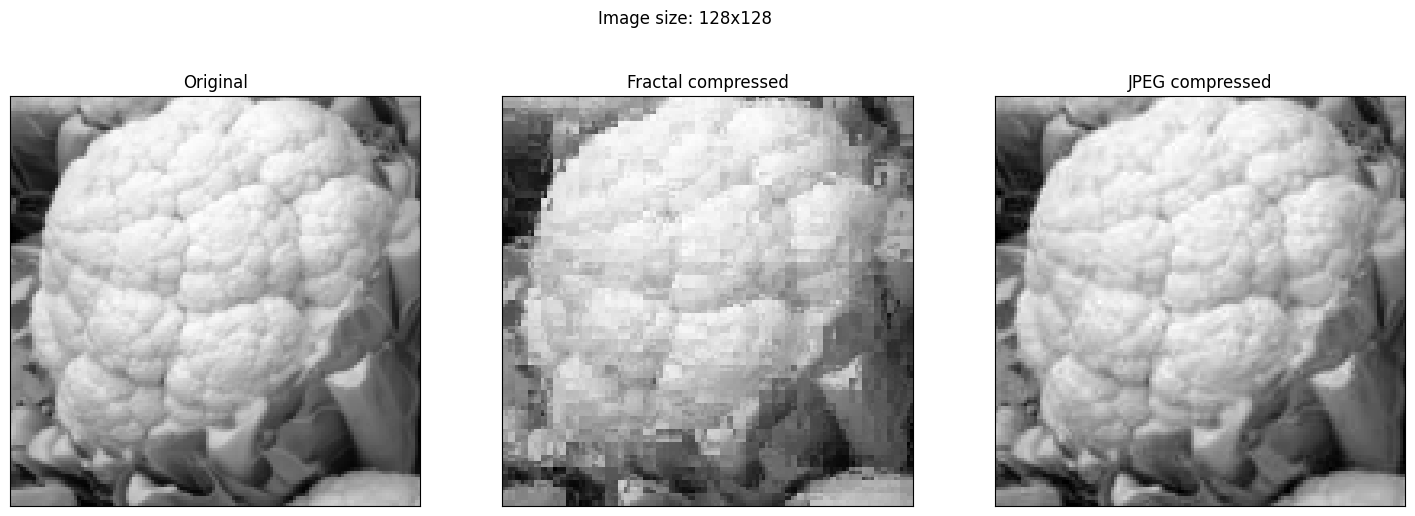

Fractal compression:
Metrics(squared_error=1857.8753994818921, mse=0.11339571530040846, psnr=33.519435355467735, encoding_time='3.7359s', decoding_time='0.2873s')
JPEG (PIL defaults):
Metrics(squared_error=541.4065016233181, mse=0.0330448304213451, psnr=38.87436652923619, encoding_time='0.0002s', decoding_time='0.0001s')


In [ ]:
img = kalafior(128)
quadtree_info = encode_decode_quadtree(img)
compare_encoding(img, quadtree_info)

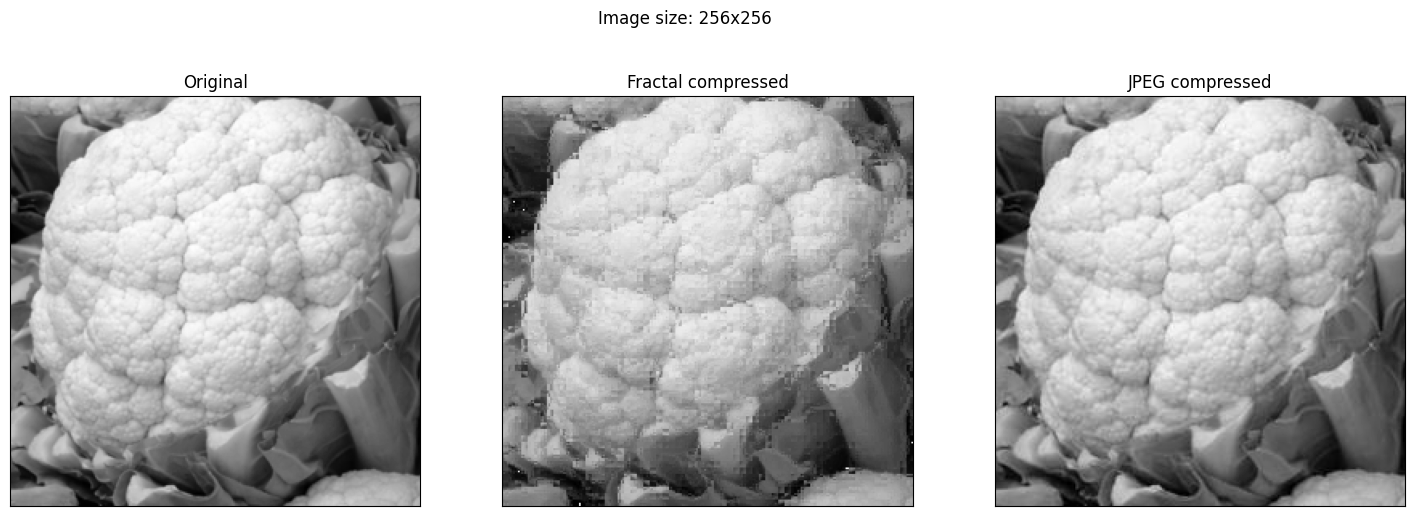

Fractal compression:
Metrics(squared_error=3145.332891762015, mse=0.04799397112673973, psnr=37.25353494534085, encoding_time='0.1873s', decoding_time='1.1196s')
JPEG (PIL defaults):
Metrics(squared_error=810.6022452473222, mse=0.012368808673817783, psnr=43.142123087193724, encoding_time='0.0002s', decoding_time='0.0002s')


In [ ]:
img = kalafior(256)
quadtree_info = encode_decode_quadtree(img)
compare_encoding(img, quadtree_info)

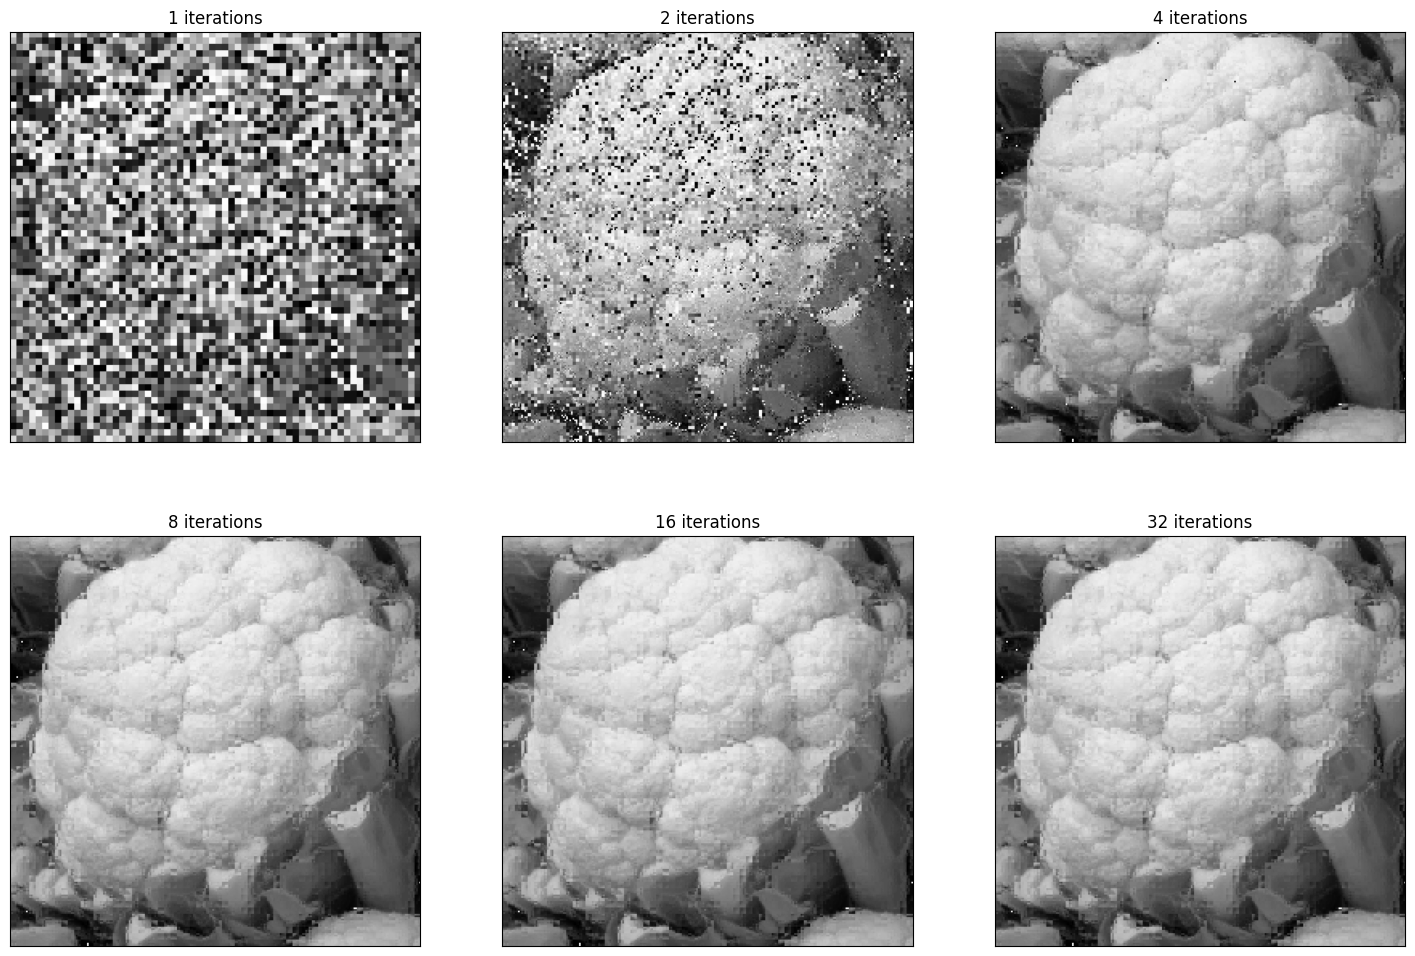

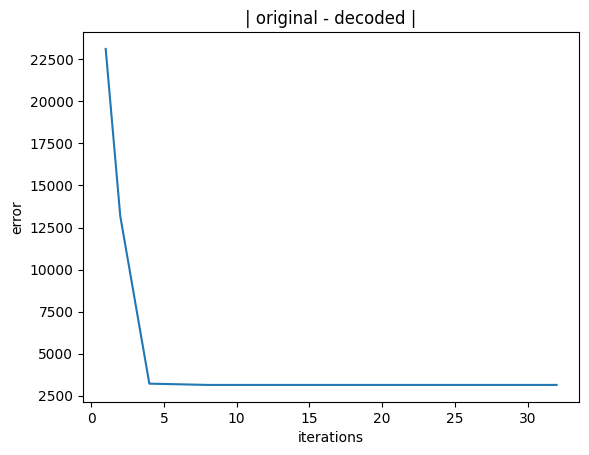

In [ ]:
def it_decoder(it_num):
    decoded = QuadtreeDecoder(img.shape[1], img.shape[0], quadtree_info.encoding).decode(it_num)
    err = np.linalg.norm(img.astype(np.int32) - decoded.astype(np.int32))
    return decoded, err
compare_per_iteration_results(it_decoder)

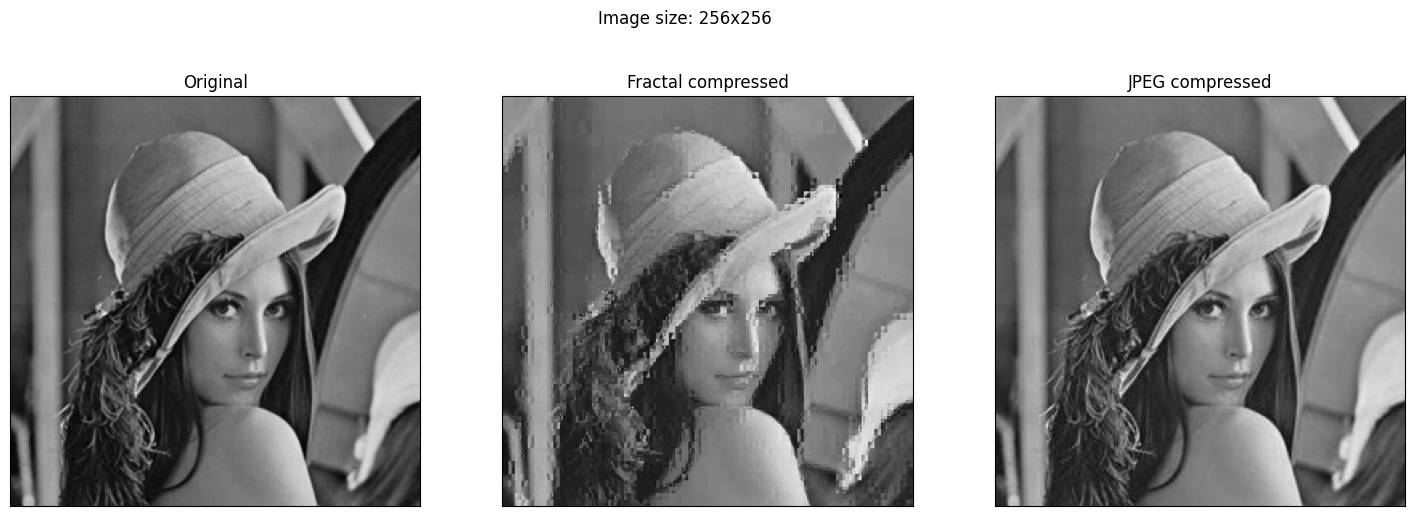

Fractal compression:
Metrics(squared_error=3730.330682392648, mse=0.0569203290160011, psnr=36.5127277866646, encoding_time='0.1194s', decoding_time='0.9879s')
JPEG (PIL defaults):
Metrics(squared_error=913.2283394639043, mse=0.01393475859777686, psnr=42.62440730926902, encoding_time='0.0002s', decoding_time='0.0003s')


In [ ]:
img = lena(256)
quadtree_info = encode_decode_quadtree(img)
compare_encoding(img, quadtree_info)

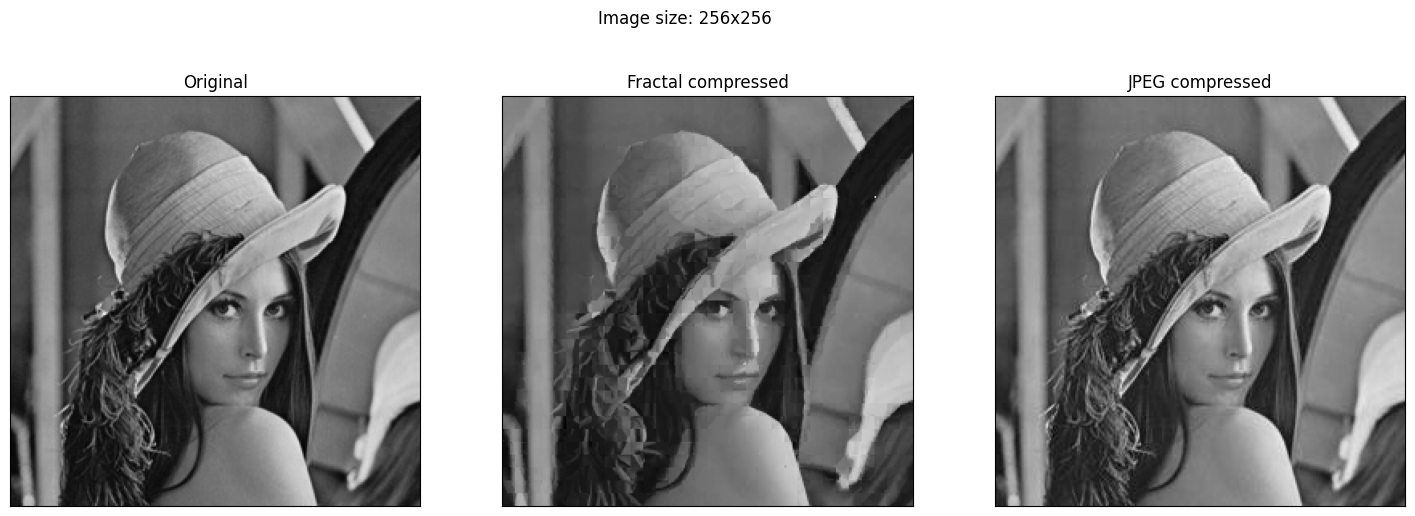

Fractal compression:
Metrics(squared_error=2065.421022455228, mse=0.0315158237068974, psnr=39.080115179748496, encoding_time='164.3073s', decoding_time='0.2695s')
JPEG (PIL defaults):
Metrics(squared_error=913.2283394639043, mse=0.01393475859777686, psnr=42.62440730926902, encoding_time='0.0002s', decoding_time='0.0002s')


In [ ]:
img = lena(256)
bruteforce_info = encode_decode_bruteforce(img)
compare_encoding(img, bruteforce_info)

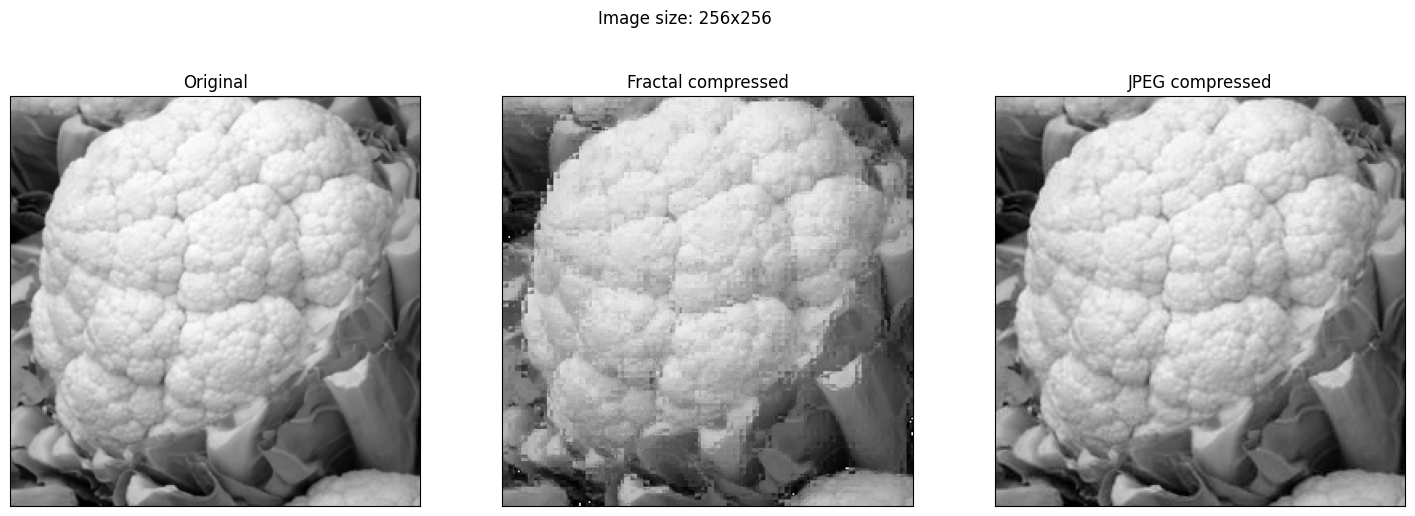

Fractal compression:
Metrics(squared_error=3168.3258986411106, mse=0.04834481656862046, psnr=37.221902636762, encoding_time='0.0377s', decoding_time='1.1485s')
JPEG (PIL defaults):
Metrics(squared_error=810.6022452473222, mse=0.012368808673817783, psnr=43.142123087193724, encoding_time='0.0002s', decoding_time='0.0002s')


In [ ]:
img = kalafior(256)
quadtree_info = encode_decode_quadtree(img, encoder=QuadtreeEncoder(EncodingInfo(5, 7, 1.), False, True, 4, 6, 2.))
compare_encoding(img, quadtree_info)

In [ ]:
def find_kalafior_encoding_params():
    img = kalafior(256)

    def f(min_partition_size, max_partition_size, error_tolerance):
        encoder = QuadtreeEncoder(1, False, False, min_partition_size, max_partition_size, error_tolerance)
        quadtree_info = encode_decode_quadtree(img, encoder=encoder)
        metrics = compute_metrics(img, quadtree_info)
        return metrics.mse # minimize mse = maximize psnr
    
    err_tol_range = np.linspace(1, 10, 20)

    min_err = np.inf
    best_params = None

    for min_part in range(3, 5):
        for max_part in range(min_part + 2, 7):
            for err_tol in err_tol_range:
                err = f(min_part, max_part, err_tol)
                if err < min_err:
                    min_err = err
                    best_params = (min_part, max_part, err_tol)
    return min_err, best_params

In [ ]:
find_kalafior_encoding_params()

(0.04799336956825079, (3, 6, 1.9473684210526314))

/home/flok3n/develop/fraccomp/src/quadtree/encoder.py:193: RuntimeWarning: invalid value encountered in sqrt
  return *best_domain, np.sqrt(err)


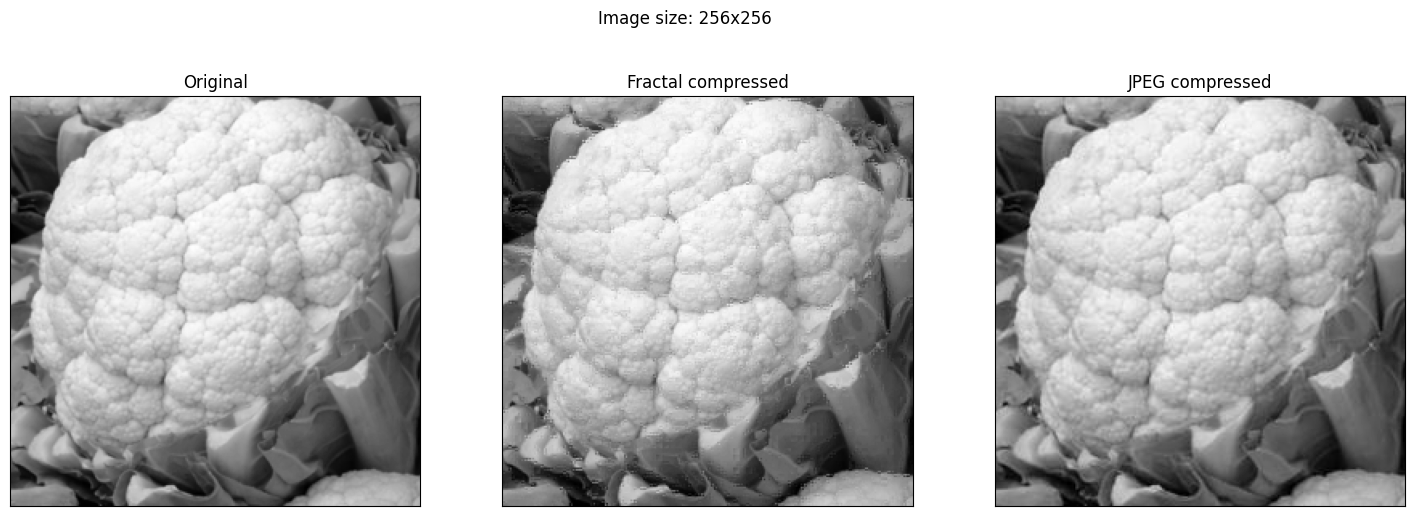

Fractal compression:
Metrics(squared_error=1708.6857522669286, mse=0.026072475467940195, psnr=39.90357912939283, encoding_time='1.0393s', decoding_time='4.1972s')
JPEG (PIL defaults):
Metrics(squared_error=810.6022452473222, mse=0.012368808673817783, psnr=43.142123087193724, encoding_time='0.0003s', decoding_time='0.0002s')


In [ ]:
img = kalafior(256)
quadtree_info = encode_decode_quadtree(img, encoder=QuadtreeEncoder(EncodingInfo(5, 7, 1.), False, False, 3, 6, 1.947))
compare_encoding(img, quadtree_info)

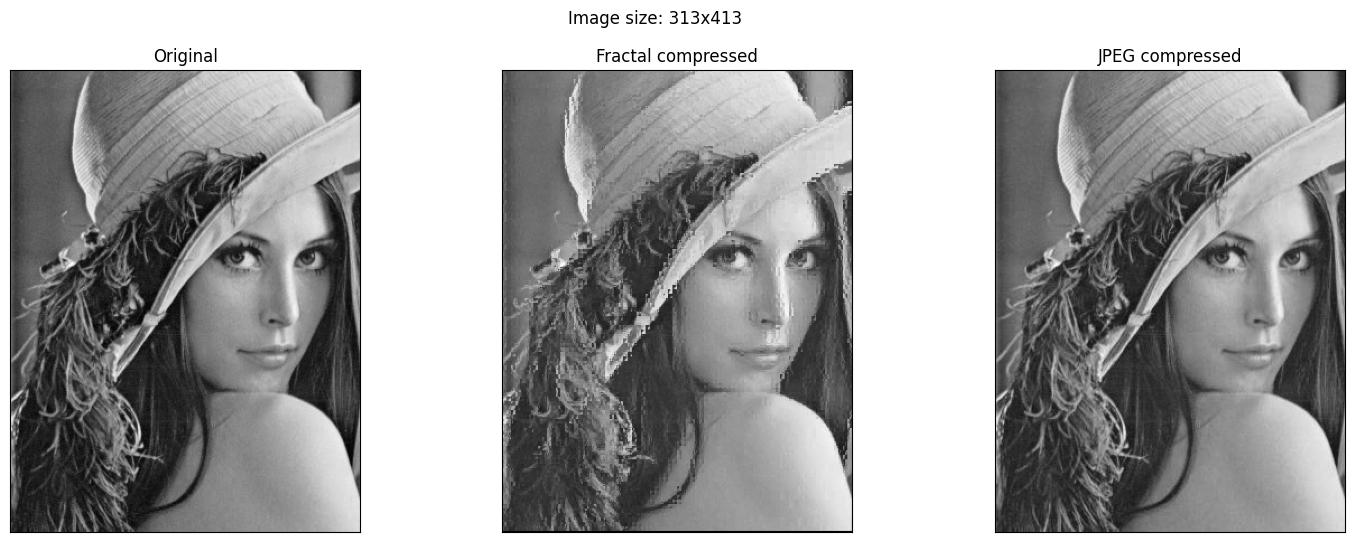

Fractal compression:
Metrics(squared_error=6124.172025670083, mse=0.04737541116331126, psnr=37.309871882719186, encoding_time='0.5268s', decoding_time='2.2389s')
JPEG (PIL defaults):
Metrics(squared_error=1379.108770184571, mse=0.010668518903871547, psnr=43.784360493434306, encoding_time='0.0003s', decoding_time='0.0003s')


In [ ]:
img = rectangular_lena(313, 413)
quadtree_info = encode_decode_quadtree(img)
compare_encoding(img, quadtree_info)

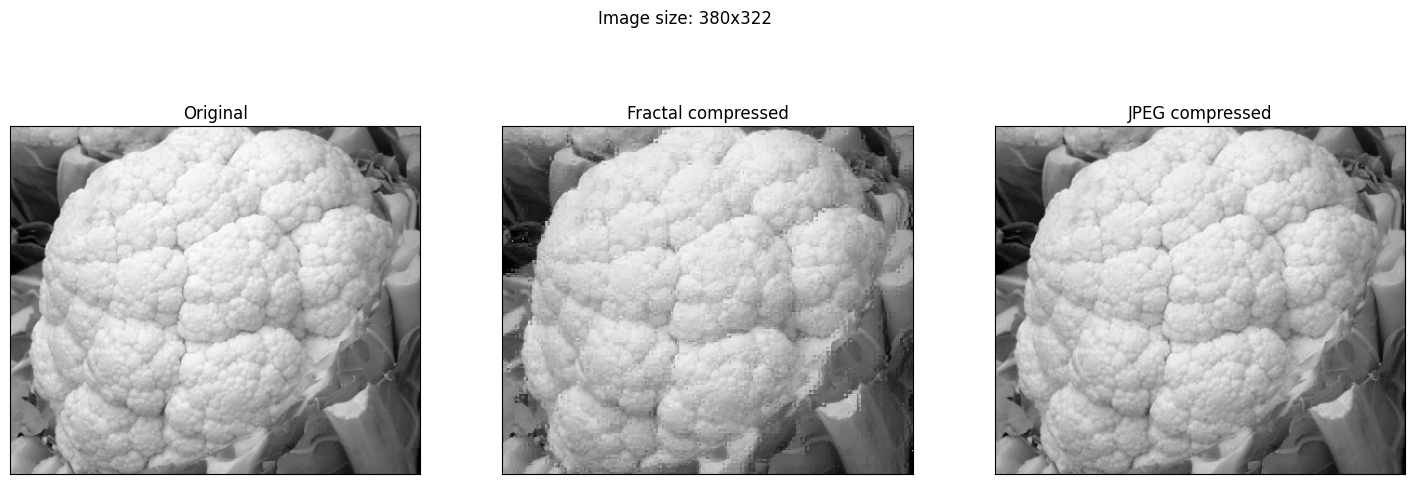

Fractal compression:
Metrics(squared_error=3270.5834341902973, mse=0.026729187922444404, psnr=39.795544160716844, encoding_time='0.5304s', decoding_time='2.1078s')
JPEG (PIL defaults):
Metrics(squared_error=1108.2450090119964, mse=0.009057249174664894, psnr=44.49543864618608, encoding_time='0.0003s', decoding_time='0.0003s')


In [ ]:
img = rectangular_kalafior(380, 322)
quadtree_info = encode_decode_quadtree(img)
compare_encoding(img, quadtree_info)

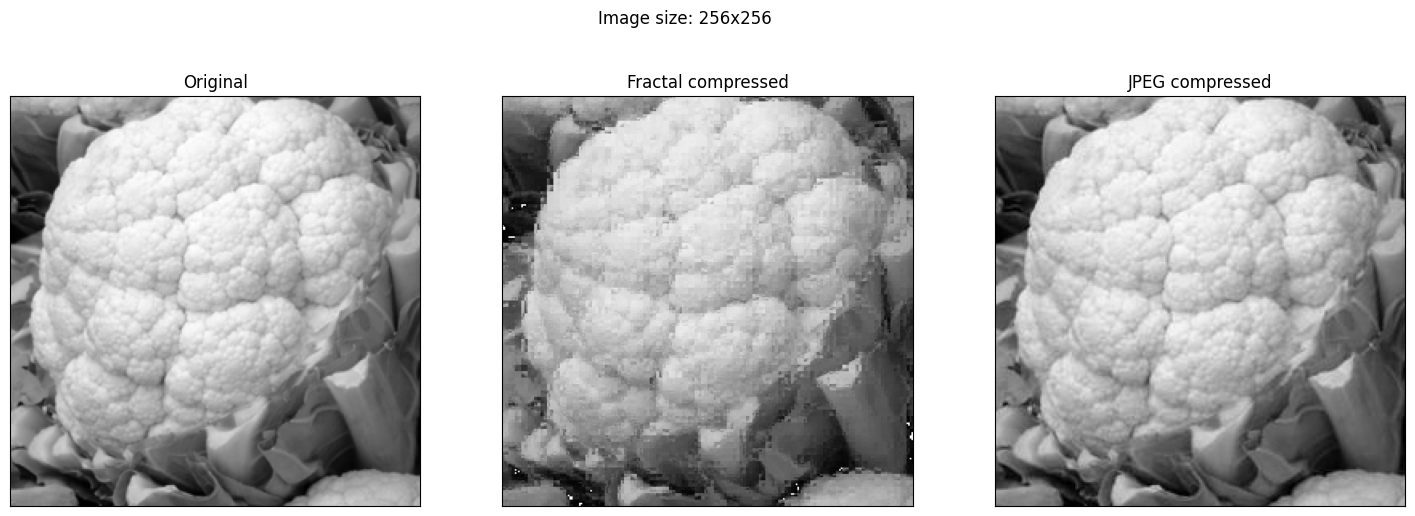

Fractal compression:
Metrics(squared_error=3611.894101437638, mse=0.05511313020992489, psnr=36.65285102482488, encoding_time='1.0000s', decoding_time='1.0000s')
JPEG (PIL defaults):
Metrics(squared_error=810.6022452473222, mse=0.012368808673817783, psnr=43.142123087193724, encoding_time='0.0002s', decoding_time='0.0002s')


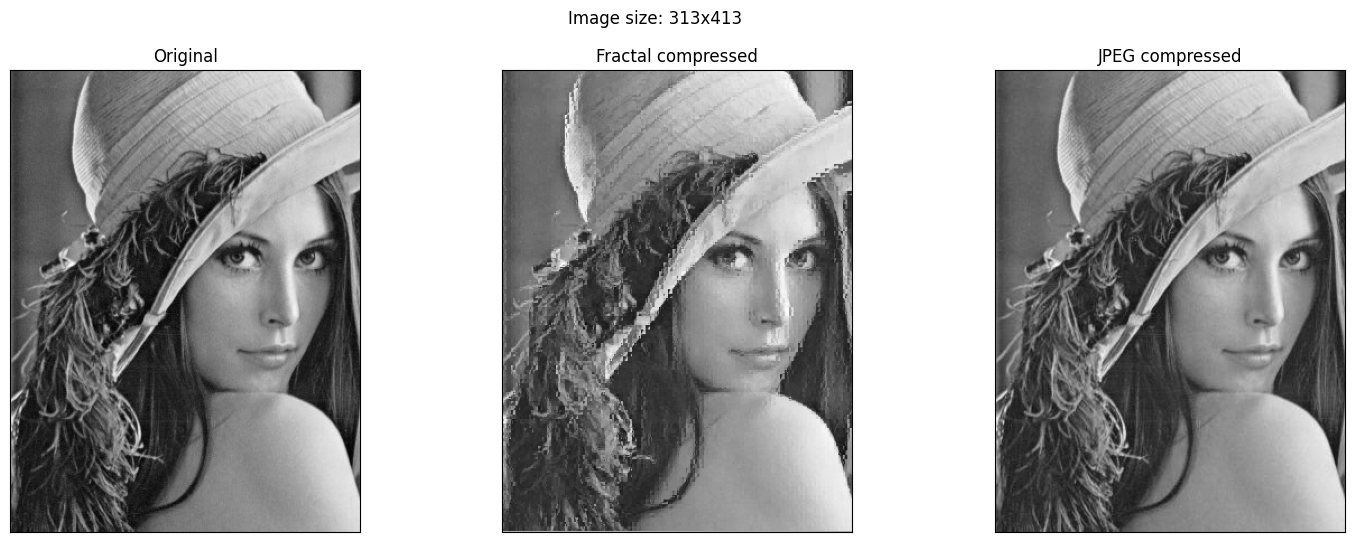

Fractal compression:
Metrics(squared_error=5481.358408278006, mse=0.04240272925665091, psnr=37.791463695262145, encoding_time='1.0000s', decoding_time='1.0000s')
JPEG (PIL defaults):
Metrics(squared_error=1379.108770184571, mse=0.010668518903871547, psnr=43.784360493434306, encoding_time='0.0003s', decoding_time='0.0004s')


In [ ]:
def test_serialization(img: np.ndarray, name: str):
    encoded = QuadtreeEncoder(7, 5, 1., False, False, 4, 32, 2.).encode(img)
    QuadtreeSerializer(encoded).serialize(f'../imgs/compressed/{name}.fqt')
    deserialized = QuadtreeDeserializer().deserialize(f'../imgs/compressed/{name}.fqt')
    decoded = QuadtreeDecoder(deserialized).decode()
    codec_info = CodecInfo(encoded, decoded, 1.0, 1., 10)
    compare_encoding(img, codec_info)

test_serialization(kalafior(256), 'kalafior256')
test_serialization(rectangular_lena(313, 413), 'lena313x413')

In [ ]:
save_grayscale('../imgs/raw/cauliflower_256x256_colored.png', '../imgs/raw/cauliflower_256x256_grayscale.png')

In [ ]:
def benchmark_compression_ratios(img_path: str):
    img = load_img(img_path)
    raw_size = os.stat(img_path).st_size

    with io.BytesIO() as bytes_io:
        Image.fromarray(img).save(bytes_io, format="JPEG")
        jpeg_size = bytes_io.tell()

    jpeg_metrics = compute_metrics(img, encode_decode_jpeg(img))

    s_range = range(4, 10)
    o_range = range(4, 8)
    # min_ranges = [2, 4, 8, 16]
    min_ranges = [2, 4]
    max_ranges = [32, 64]
    err_tols = [2., 4., 6., 8.]

    psnrs = []
    sizes = []

    configs = list(it.product(s_range, o_range, min_ranges, max_ranges, err_tols))
    for s, o, min_range, max_range, err_tol in tqdm(configs):
        if min_range >= max_range:
            continue
        encoder = QuadtreeEncoder(s, o, 1, False, False, min_range, max_range, err_tol)
        encoding = encoder.encode(img)
        decoded = QuadtreeDecoder(encoding).decode(iterations=8)
        psnrs.append(compute_metrics(img, CodecInfo(encoding, decoded, 1., 1., 8)).psnr)
        with io.BytesIO() as bytes_io:
            QuadtreeSerializer(encoding).serialize(bytes_io)
            sizes.append(bytes_io.tell())

    return configs, psnrs, sizes, raw_size, jpeg_size, jpeg_metrics.psnr

def visualize_with_plotly(configs, psnrs, sizes, raw_size, title):
    data = np.hstack([np.array(configs), np.array(psnrs).reshape((-1, 1)), np.array(sizes).reshape((-1, 1))])
    df = pd.DataFrame(data, columns=['scale_bits', 'offset_bits', 'min_range_size', 'max_range_size', 'err_tol', 'psnr', 'size'])
    df['compression_ratio'] = df['size'].apply(lambda size: raw_size / size)

    fig = px.scatter(df, x='psnr', y='compression_ratio', hover_data={k: True for k in df.columns}, title=title)
    fig.update_layout()
    fig.show()

In [ ]:
configs, psnrs, sizes, raw_size, jpeg_size, jpeg_psnr = benchmark_compression_ratios('../imgs/raw/cauliflower_256x256_grayscale.png')

100%|██████████| 140/140 [01:03<00:00,  2.21it/s]


In [ ]:
print(f'Original size: {raw_size}\tjpeg_size: {jpeg_size}\tjpeg_psnr: {jpeg_psnr}\tjpeg_compreesion_rate: {raw_size / jpeg_size}')
visualize_with_plotly(configs, psnrs, sizes, raw_size, title='cauliflower 256x256')

Original size: 38222	jpeg_size: 11084	jpeg_psnr: 43.142123087193724	jpeg_compreesion_rate: 3.448394081559004


In [ ]:
configs, psnrs, sizes, raw_size, jpeg_size, jpeg_psnr = benchmark_compression_ratios('../imgs/raw/lena_313x413_colored.bmp')

  0%|          | 0/384 [00:00<?, ?it/s]

100%|██████████| 384/384 [15:51<00:00,  2.48s/it]


In [ ]:
print(f'Original size: {raw_size}\tjpeg_size: {jpeg_size}\tjpeg_psnr: {jpeg_psnr}\tjpeg_compreesion_rate: {raw_size / jpeg_size}')
visualize_with_plotly(configs, psnrs, sizes, raw_size, title='lena 313x413')

Original size: 388358	jpeg_size: 21211	jpeg_psnr: 43.784360493434306	jpeg_compreesion_rate: 18.309273490170195
